## Clasificación en topics según similaritud

Técnica de clasificación de documento no supervisada para agruparlos por temáticas similares.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.datasets import fetch_20newsgroups   #NLTK, gensim, 
from gensim.parsing.preprocessing import STOPWORDS # 20 grupo de noticias 

from sklearn.feature_extraction.text import TfidfVectorizer#
from sklearn.feature_extraction.text import CountVectorizer#


from numpy.linalg import svd


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\daalu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
db = pd.read_csv('MovieLens_con_argumento.csv')
pelis=pd.DataFrame(db)

dataset=np.array(pelis)
pelis





,movieId,title,genres,argumento
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,A cowboy doll is profoundly threatened and jea...
1,2,Jumanji (1995),Adventure|Children|Fantasy,When two kids find and play a magical board ga...
2,3,Grumpier Old Men (1995),Comedy|Romance,John and Max resolve to save their beloved bai...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"Based on Terry McMillan's novel, this film fol..."
4,5,Father of the Bride Part II (1995),Comedy,George Banks must deal not only with the pregn...
...,...,...,...,...
9727,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,A young lord and his demon butler board a luxu...
9728,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,"Adaption of the sixth Light Novel of series, i..."
9729,193585,Flint (2017),Drama,A woman deals with the toxic water scandal in ...
9730,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Rivalry between groups of criminals and detect...


Reconocimeinto del Dataset

In [3]:

print(pelis.describe())
print(pelis['genres'])

             movieId
count    9732.000000
mean    42148.408652
std     52117.537758
min         1.000000
25%      3247.750000
50%      7295.500000
75%     76105.500000
max    193609.000000
0       Adventure|Animation|Children|Comedy|Fantasy
1                        Adventure|Children|Fantasy
2                                    Comedy|Romance
3                              Comedy|Drama|Romance
4                                            Comedy
                           ...                     
9727                Action|Animation|Comedy|Fantasy
9728                       Animation|Comedy|Fantasy
9729                                          Drama
9730                               Action|Animation
9731                                         Comedy
Name: genres, Length: 9732, dtype: object


In [30]:
#df = pd.DataFrame({'documentos':docs})

In [31]:
STOPWORDS

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [4]:
#Limpieza de texto
pelis['doc_limpio'] =  pelis['argumento'].str.replace("[^a-zA-Z#]", " ")# deja solo letras no simbolos 
#df['doc_limpio']  = df['doc_limpio'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]).lower() )#funcion lamda se queda con  ensaje s co >3 topiing   y minusculas 
pelis['doc_limpio']  = pelis['doc_limpio'].apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS]))#stopwords son las palabras conetores 

C:\Users\daalu\AppData\Local\Temp\ipykernel_492\2676762846.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  pelis['doc_limpio'] =  pelis['argumento'].str.replace("[^a-zA-Z#]", " ")# deja solo letras no simbolos


In [33]:
df

,documentos,doc_limpio
0,Well i'm not sure about the story nad it did s...,Well m sure story nad biased What I disagree s...
1,"\n\n\n\n\n\n\nYeah, do you expect people to re...",Yeah expect people read FAQ actually accept ha...
2,Although I realize that principle is not one o...,Although I realize principle strongest points ...
3,Notwithstanding all the legitimate fuss about ...,Notwithstanding legitimate fuss proposal chang...
4,"Well, I will have to change the scoring on my ...",Well I change scoring playoff pool Unfortunate...
...,...,...
11309,"Danny Rubenstein, an Israeli journalist, will ...",Danny Rubenstein Israeli journalist speaking t...
11310,\n,
11311,\nI agree. Home runs off Clemens are always m...,I agree Home runs Clemens memorable Kinda like...
11312,I used HP DeskJet with Orange Micros Grappler ...,I HP DeskJet Orange Micros Grappler LS System ...


## Vectorización

Para transformar los documentos en vectores hay por lo menos dos opciones. Una es el conteo de cada token en los documentos. Y otra es usando ``tf-idf`` (*Term Frequency - Inverse Document Frequency*)

$$
\operatorname{tf}(t,d) = 0.5 + 0.5\frac {f_{t,d}} {\max \{ f_{t',d} : t' \in D\}}
$$

  tf es la frecuacia de los terminos en los documentos d, cuantas veces se normaliza cuantas veces esta un termino en el documetno e suna frencuencan
y 

$$
\operatorname{idf}(t,D)  = \log \left(\frac {|D|} {1+ |\{d \in D : t \in D \} |} \right)
$$

id es un periodo que tan popular es un termino a lo largo de todos los documentos 
d \in D la cantidad de terminos en el docmuento 

entonces el _score_ por término es

$$
\operatorname{tf-idf}(t,d,D) = \operatorname{tf}(t,d) \times \operatorname{idf}(t,D)
$$
 se multiplica el score de cada docmento 
 El ejemplo en [Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Example_of_tf%E2%80%93idf)

In [36]:
#vectorizador = CountVectorizer(stop_words='english', max_features=1000)
vectorizador = TfidfVectorizer(stop_words='english', max_features=1000, max_df=0.5, smooth_idf=True)
X            = vectorizador.fit_transform(pelis['doc_limpio'])# agarra una matriz de datos aplica tf y idf acada docmeunto, lo entrana con fit y los tranforma 
X
# los datos se guarda en X se convierte en arreglo porque  tiene mucho ceros 

<9732x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 70314 stored elements in Compressed Sparse Row format>

In [37]:
Xa  = X.toarray()
Xa[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [38]:
Xa.shape

(9732, 1000)

In [39]:
u, s, vt = svd(Xa, full_matrices=False) # e implementa svd de numpy 

In [40]:
u.shape

(9732, 1000)

In [41]:
vt.shape

(1000, 1000)

In [42]:
s.shape

(1000,)

In [44]:
reconstruye = lambda p,s,q,n : np.dot( 
                                      np.dot(p[:,:n], np.diag(s[:n])), 
                                      q[:n]) # toma los tres matrices con cuantos valores sigulares se recostruye producto punto por [p .S]y luego por vtranspuesta  

recomp = reconstruye(u,s,vt,1000)# se recostruye 
recomp.shape


(9732, 1000)

In [45]:
np.allclose(Xa, recomp) # que tan iguales son dos matrices 

True

<AxesSubplot:>

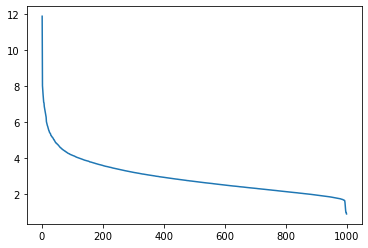

In [46]:
sns.lineplot(x=range(1,len(s)+1), y=s) # revisar la varianza ya no necsita solo dos valores 

<AxesSubplot:>

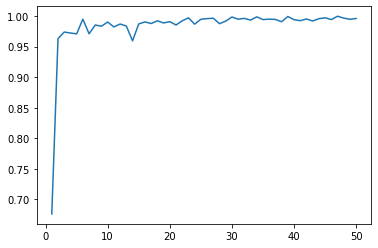

In [63]:
w = [s[i+1]/s[i] for i in range(len(s)-1)]
sns.lineplot(x = range(1,51), y=w[:50]) # con canto valores se queda 20 terminos antes de que se vueva recta 

**Comentario**:
El producto Escalar asemeja dos vectores cuando el agunlo que se forma entre ellos es cero. 
Esto implica maxima similitud entre dos vectores

In [56]:
R = reconstruye(u,s,vt, 10) # la matrix reocnstruida con 10 valores singulares ( con imagenes se requirio 2 parámetros  aca se necesitan más )
R.shape # los vectores se van a parecer mientras más parecido sean con un valor singualar 


(11314, 1000)

In [48]:
terms = vectorizador.get_feature_names()# todas las palabras ordenados 
len(terms)

1000

In [49]:
print(pelis.iloc[2032]['doc_limpio']) # recuepar el domcuento 2032 

Gonzo contacted alien family breakfast cereal But men black kidnap s Kermit gang rescue Gonzo help reunite long lost family


In [50]:
# en que docuemtno esta e aterior texto 
vector = vectorizador.transform(['Gonzo contacted alien family breakfast cereal But men black kidnap s Kermit gang rescue Gonzo help reunite long lost family, raymond ingles ingles@engin.umich.edu'])
varr   = vector.toarray()
varr.shape 
# automaticamenete escoge los termino y hace una matride 1 y ceros 

(1, 1000)

In [53]:
dh = np.dot(recomp, varr.T )# que documento se acerca mas productno punto de la recomposicion el vector los 
np.round(dh, decimals=3) # busca que vecnto se le pare el .dot

array([[0.   ],
       [0.   ],
       [0.   ],
       ...,
       [0.174],
       [0.083],
       [0.   ]])

In [54]:
p = np.argsort(dh.reshape(1,-1))# ordena de mayor a menro todas al entrdas 
p[0][-5:]# muestra 5 entradas 

array([8771, 1271, 1583, 5751, 2032], dtype=int64)

In [56]:
print(pelis.iloc[8771]['doc_limpio'])

Stitch alien living Earth disguised dog human family continues adventures discovers alien family knew Hawaii hunted galactic forces


In [58]:
print(pelis.iloc[2032]['doc_limpio'])

Gonzo contacted alien family breakfast cereal But men black kidnap s Kermit gang rescue Gonzo help reunite long lost family


In [59]:
k = 10
vocab = vectorizador.vocabulary_
for i, componente in enumerate(vt): # cada fila de vt la base de los terminos 
    vocab_comp = zip(terms, componente)# hay 1000 terminos 
    jerarquia_temas = sorted(vocab_comp, key=lambda x:x[1], reverse=True)[:k]# se empata vt y term  , x1 es la entrdada de la componente  
    print(u"Tópico {}".format(i)) # se muetra el vector like es el priemr topico
    for temas in jerarquia_temas:
        print("\t {} {}".format(temas[0], temas[1]))
    print("*"*50)

Tópico 0
	 unit -0.0053160989043710555
	 anti -0.005403165970075526
	 culture -0.005434912275614271
	 david -0.005579067603368249
	 producer -0.005589138743017676
	 uncovers -0.005649278449114769
	 hitman -0.005657485389812213
	 national -0.005743552312647119
	 industry -0.0057533655494336165
	 collection -0.005758681648844385
**************************************************
Tópico 1
	 new 0.4003403200180031
	 york 0.23184493551136248
	 city 0.21519262566185637
	 school 0.181933173766805
	 high 0.1459755034020631
	 group 0.11653853179985346
	 life 0.08752418898293665
	 world 0.08509292213745917
	 friends 0.08352781415758757
	 year 0.07076015709817508
**************************************************
Tópico 2
	 new 0.28261875904586803
	 young 0.1982340287870326
	 york 0.1716051599486553
	 city 0.14812465085761584
	 woman 0.12661898998782287
	 town 0.06568593325460091
	 group 0.06389441478616685
	 school 0.0636001157921075
	 small 0.050367839614977275
	 help 0.05015886794212474
******

	 trip 0.11501772046066253
	 arts 0.10904898026390686
	 doctor 0.10469903151835908
**************************************************
Tópico 109
	 career 0.22593170332680906
	 trying 0.15792537053031996
	 save 0.14396420804329085
	 job 0.13999623315393858
	 live 0.13632692526868798
	 sets 0.1292721962990056
	 criminal 0.11961650982882928
	 long 0.11744584196814872
	 book 0.11471748421711839
	 based 0.11423231646070113
**************************************************
Tópico 110
	 revenge 0.19052833444662698
	 black 0.17213859001501433
	 like 0.1482140658749197
	 accident 0.13864771086593622
	 car 0.12285408001971292
	 run 0.1226437587647258
	 criminal 0.12167780104698521
	 student 0.11488610462197163
	 return 0.11388623971050313
	 scientist 0.10615910875181708
**************************************************
Tópico 111
	 middle 0.23041121926988553
	 class 0.17523336241017906
	 female 0.16753528236628434
	 stories 0.145156073332744
	 wants 0.1402779206966714
	 aged 0.1293711248530421

Tópico 228
	 artist 0.14341062807060884
	 lover 0.12960167332486852
	 government 0.12448912873692812
	 events 0.11345200522869041
	 japanese 0.1090726639470343
	 famous 0.10596478409213293
	 rich 0.0984430531510397
	 book 0.09708811873704759
	 dreams 0.09235652920416428
	 single 0.09216156434525395
**************************************************
Tópico 229
	 escape 0.19585083000176567
	 space 0.1456822777669496
	 hollywood 0.13385466323090198
	 deadly 0.1294399679468472
	 san 0.12528649694668637
	 adventure 0.12383653761952097
	 party 0.1165218160017947
	 successful 0.11642238309557129
	 francisco 0.11282554909279516
	 vegas 0.1106601984691552
**************************************************
Tópico 230
	 sex 0.2887443735631579
	 romantic 0.18814165941152408
	 married 0.1257002786146158
	 space 0.12411827678831149
	 dog 0.10276676613994565
	 strange 0.10215275195788205
	 journalist 0.09629845199648143
	 vacation 0.09535706916275481
	 short 0.09026053428053323
	 military 0.086460859

Tópico 355
	 prove 0.12185516965916254
	 shot 0.10866332699418293
	 truth 0.10791626620681745
	 tells 0.10757423747923588
	 hunter 0.10562517375398996
	 california 0.10310036059257362
	 want 0.09754477891418747
	 short 0.09742685046730869
	 follows 0.08911615936134139
	 investigate 0.08205435440982221
**************************************************
Tópico 356
	 brutal 0.130870024634131
	 farm 0.1297680749936499
	 films 0.11987897139213696
	 businessman 0.11891492940091705
	 military 0.11514149682476538
	 loves 0.10454370166729597
	 street 0.10420901543102967
	 television 0.10247976492343229
	 lord 0.10108390564595124
	 single 0.10090350800604261
**************************************************
Tópico 357
	 seven 0.16478441664748494
	 characters 0.12372259628989954
	 use 0.12255248801043836
	 encounter 0.12093602811937601
	 head 0.11742465606097012
	 truth 0.09474509684644852
	 murdered 0.09293829473695929
	 community 0.0919085157680826
	 criminals 0.09154828213020028
	 prove 0.089

Tópico 474
	 park 0.1719976289915357
	 tough 0.16511510416894917
	 lonely 0.11999435049544395
	 japan 0.10797295094599019
	 hostage 0.10346247087023765
	 families 0.0938080110902805
	 members 0.0910963121048666
	 begin 0.08903398043695242
	 following 0.08709128266793663
	 grows 0.08649972682115231
**************************************************
Tópico 475
	 teenagers 0.11940117226552902
	 international 0.1193180145490381
	 experiences 0.1021700659417855
	 stranded 0.10117358928586542
	 deal 0.09949389772596517
	 eccentric 0.09826776748499055
	 suburban 0.09545920055046314
	 water 0.0920156856480188
	 horror 0.09045230924785498
	 prevent 0.08653703324270262
**************************************************
Tópico 476
	 consequences 0.14877234579051707
	 unexpected 0.12547799815430305
	 sends 0.11102163469114122
	 crisis 0.10623160082695626
	 bizarre 0.10176817149227868
	 chicago 0.09875866207963031
	 looks 0.09757859516700176
	 italian 0.0975710963441814
	 fortune 0.0959015705903873

Tópico 600
	 assistant 0.13919490603660847
	 paul 0.13467296388186997
	 gives 0.12217222941508811
	 aging 0.11590801926055425
	 seemingly 0.09663311136456407
	 hope 0.09433586955899957
	 gay 0.09210843483325011
	 weekend 0.08931026845961888
	 affair 0.08641988815867745
	 harry 0.08260496338597596
**************************************************
Tópico 601
	 wishes 0.1616419089426453
	 coming 0.11811400191727454
	 told 0.10651577121022407
	 complicated 0.10629851203873794
	 memories 0.1045859432499527
	 suburban 0.10341915225387414
	 course 0.10329896776555303
	 powers 0.09475562155815663
	 seek 0.09220151627383097
	 cat 0.09121558540978973
**************************************************
Tópico 602
	 desperate 0.14438057666925172
	 winning 0.1312337203289444
	 behavior 0.12424989582952123
	 author 0.11375905300192957
	 monster 0.09810265676720929
	 central 0.09340586039922605
	 idea 0.0892893834639328
	 shy 0.08785282278466906
	 develops 0.08519664339961089
	 seen 0.079928638300136

	 talking 0.09416939567831777
	 seen 0.09381203790737215
	 office 0.09307196711784949
**************************************************
Tópico 733
	 assistant 0.14798103852806646
	 situation 0.12634621459994716
	 suspect 0.10217978246505743
	 victim 0.09996763216703326
	 germany 0.09743521735473835
	 assigned 0.09234974439530097
	 vietnam 0.09177841641317043
	 monsters 0.08987604137448625
	 enter 0.08925172000505992
	 forms 0.08833671529665303
**************************************************
Tópico 734
	 peter 0.12508195833547295
	 vampires 0.1236378983602272
	 victim 0.10068211340119085
	 vengeance 0.09000022218585767
	 musician 0.08972727785180673
	 university 0.0857384143658017
	 seemingly 0.08482060469126076
	 disappearance 0.08469808906789442
	 wishes 0.08401106563802711
	 media 0.08155017620762965
**************************************************
Tópico 735
	 increasingly 0.14998739367219152
	 hometown 0.13028203221395457
	 weekend 0.10446614684844417
	 memory 0.0991392596148

Tópico 843
	 alive 0.16982053005823597
	 memories 0.14382494558670691
	 kills 0.12268910316999078
	 killers 0.11853971739311789
	 better 0.11375253093624194
	 months 0.11289792515432173
	 novelist 0.1049931800157328
	 loses 0.10443707660816845
	 hunting 0.10431817566651778
	 receives 0.10014879561763074
**************************************************
Tópico 844
	 university 0.12180368811310398
	 nurse 0.1189994745181828
	 survival 0.11535900359431009
	 catch 0.10964539712326063
	 gain 0.10932115979622052
	 author 0.09872303115044237
	 dad 0.09776932133453729
	 retirement 0.09679523578836204
	 cause 0.09629483693875086
	 kong 0.09195087973771822
**************************************************
Tópico 845
	 trio 0.14082741853975753
	 machine 0.11897979321811612
	 arrival 0.11280900861273363
	 alcoholic 0.10929821793889817
	 share 0.10695302998870625
	 inspired 0.10246379922913694
	 underground 0.10242685036777815
	 robert 0.09884205251780823
	 unexpectedly 0.09506818598670085
	 inve

	 capture 0.11690725978381447
	 count 0.11312695622757277
	 receives 0.11094207027664202
	 arrival 0.1104342875960308
	 vengeance 0.10945454787173577
**************************************************
Tópico 954
	 weapon 0.21769095086610205
	 forever 0.19253640728139837
	 church 0.16741164953488397
	 finally 0.15079518432917058
	 baseball 0.13181202317215066
	 blood 0.10926332622253489
	 wakes 0.09437788807679388
	 survival 0.09158938402192293
	 assassination 0.0909809758222876
	 need 0.08984518006282562
**************************************************
Tópico 955
	 held 0.17546643560040992
	 need 0.16214856769166727
	 church 0.1463046454343818
	 video 0.14284168206396988
	 salesman 0.13349700759150787
	 distant 0.12818467786820098
	 quickly 0.12591074203056934
	 kong 0.11575609902310662
	 farmer 0.10613493417353813
	 kingdom 0.09797803466058409
**************************************************
Tópico 956
	 air 0.1655350255553518
	 policeman 0.1569926839426793
	 farmer 0.132281831336

**Cada tópico es una tema en general según las palabras**

In [62]:
len(vocab)

1000